## CS441: Applied ML - HW 4

### Part 1: Model Complexity and Tree-based Regressors

One measure of a tree’s complexity is the maximum tree depth. Train tree, random forest, and boosted tree regressors on the temperature regression task, using all default parameters except:


*   max_depth={2,4,8,16,32}
*   random_state=0
*   For random forest: max_features=1/3

Measure train and val RMSE for each and plot them all on the same plot using the provided plot_depth_error function. You should have six lines (train/val for each model type), each with 5 data points (one for each max depth value).  Include the plot and answer the analysis questions in the report.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# load data (modify to match your data directory or comment)
def load_temp_data():
  datadir = "./"
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target temperature
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()

# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

In [2]:
# to plot the errors
def plot_depth_error(max_depths, tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err):
  plt.figure()
  plt.semilogx(max_depths, tree_train_err, 'r.--',label='tree train')
  plt.semilogx(max_depths, tree_val_err, 'r.-', label='tree val')
  plt.semilogx(max_depths, rf_train_err, 'g.--',label='RF train')
  plt.semilogx(max_depths, rf_val_err, 'g.-', label='RF val')
  plt.semilogx(max_depths, bt_train_err, 'b.--',label='BT train')
  plt.semilogx(max_depths, bt_val_err, 'b.-', label='BT val')
  plt.ylabel('RMSE Error')
  plt.xlabel('Max Tree Depth')
  plt.xticks(max_depths, max_depths)
  plt.legend()
  plt.rcParams.update({'font.size': 20})
  plt.show()

100%|██████████| 5/5 [03:30<00:00, 42.13s/it]


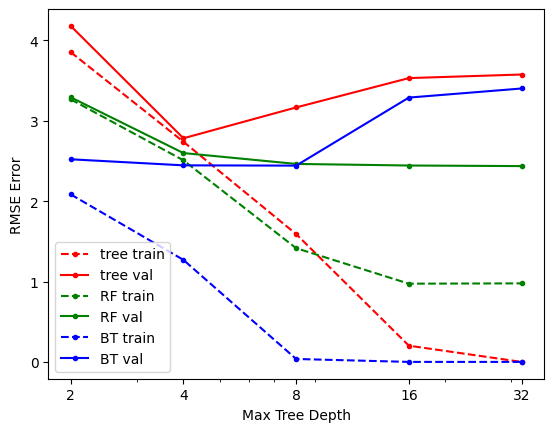

In [3]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tqdm import tqdm

max_depths = [2,4,8,16,32]
rmse1 = []
rmse2 = []
rmse3 = []
rmse4 = []
rmse5 = []
rmse6 = []
for depth in tqdm(max_depths):
  model1 = DecisionTreeRegressor(random_state=0, max_depth=depth)
  model2 = RandomForestRegressor(random_state=0, max_depth=depth, max_features=1/3)
  model3 = GradientBoostingRegressor(random_state=0, max_depth=depth)
  
  model1.fit(x_train, y_train)
  y_pred1 = model1.predict(x_train)
  rmse1.append(np.sqrt(np.mean((y_train-y_pred1)**2)))
  y_pred2 = model1.predict(x_val)
  rmse2.append(np.sqrt(np.mean((y_val-y_pred2)**2)))
  
  model2.fit(x_train, y_train)
  y_pred3 = model2.predict(x_train)
  rmse3.append(np.sqrt(np.mean((y_train-y_pred3)**2)))
  y_pred4 = model2.predict(x_val)
  rmse4.append(np.sqrt(np.mean((y_val-y_pred4)**2)))
  
  model3.fit(x_train, y_train)
  y_pred5 = model3.predict(x_train)
  rmse5.append(np.sqrt(np.mean((y_train-y_pred5)**2)))
  y_pred6 = model3.predict(x_val)
  rmse6.append(np.sqrt(np.mean((y_val-y_pred6)**2)))
  
plot_depth_error(max_depths, rmse1, rmse2, rmse3, rmse4, rmse5, rmse6)



### Part 2: MLPs with MNIST

For this part, you will want to use a GPU to improve runtime. Google Colab provides limited free GPU acceleration to all users. Go to Runtime and change Runtime Type to GPU.  This will reset your compute node, so do it before starting to run other cells.

See [Tips](https://docs.google.com/document/d/1_kV9x1LCAFfe6UqY22eqj2eqdCZh72oQDf60zRo2ydM/edit?usp=drive_link) for detailed guidance on this problem.

First, use PyTorch to implement a Multilayer Perceptron network with one hidden layer (size 64) with ReLU activation. Set the network to minimize cross-entropy loss, which is the negative log probability of the training labels given the training features. This objective function takes unnormalized logits as inputs.

*Do not use MLP in sklearn for this HW - use Torch*.

In [4]:
# initialization code
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot as plt
from scipy import stats
import torch
import torch.nn as nn

def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

In [5]:
# Sets device to "cuda" if a GPU is available  (in Colabs, enable GPU by Edit->Notebook Settings-->Hardware Accelerator=GPU)
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device) # make sure you're using GPU instance

cpu


#### 2a
Using the train/val split provided in the starter code, train your network for 100 epochs with learning rates of 0.01, 0.1, and 1.  Use a batch size of 256 and the SGD optimizer.  After each epoch, record the mean training and validation loss and compute the validation error of the final model. The mean validation loss should be computed after the epoch is complete.  The mean training loss can either be computed after the epoch is complete, or, for efficiency, computed using the losses accumulated during the training of the epoch.  Plot the training and validation losses using the display_error_curves function.

In [6]:
(x_train, y_train), (x_test, y_test) = load_mnist()

# create train/val split
ntrain = 50000
x_val = x_train[ntrain:].copy()
y_val = y_train[ntrain:].copy()
x_train = x_train[:ntrain]
y_train = y_train[:ntrain]

In [7]:
def display_error_curves(training_losses, validation_losses):
  """
  Plots the training and validation loss curves
  training_losses and validation_losses should be lists or arrays of the same length
  """
  num_epochs = len(training_losses)

  plt.plot(range(num_epochs), training_losses, label="Training Loss")
  plt.plot(range(num_epochs), validation_losses, label="Validation Loss")

  # Add in a title and axes labels
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  # Display the plot
  plt.legend(loc='best')
  plt.show()

In [8]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # Needs code here
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
      # Needs code here
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      return x

In [13]:
# This is a possible function definition for training MLP, but feel free to change it
# You may also want to create helper functions, e.g. for computing loss or prediction
import torch
import torch.nn as nn
import torch.optim as optim

def train_MLP_mnist(train_loader, val_loader, lr=1e-1, num_epochs=100):
  '''
  Train a MLP
  Input: train_loader and val_loader are dataloaders for the training and
  val data, respectively. lr is the learning rate, and the network will
  be trained for num_epochs epochs.
  Output: return a trained MLP
  '''
  # TODO: fill in all code

  input_size = 784
  hidden_size = 64
  output_size = 10

  # Instantiate the model
  mlp = MLP(input_size, hidden_size, output_size)
  optimizer = optim.SGD(mlp.parameters(), lr=lr)
  training_losses, validation_losses = [], []
  loss_function = torch.nn.CrossEntropyLoss()
  
  # Train the model, compute and store train/val loss at each epoch
  for epoch in tqdm(range(0, num_epochs), desc=f"learning rate = {lr}"):    
    # Iterate over the DataLoader for training data
    
    sum_train = 0
    sum_val = 0
    
    for i, data in enumerate(train_loader, 0):    
      inputs, targets = data # Get inputs  
      optimizer.zero_grad() # Zero the gradients
      outputs = mlp(inputs) # Compute logit scores for current batch
      loss = loss_function(outputs, targets) # Compute loss
      loss.backward() # Backprop loss
      optimizer.step() # Update weights
      sum_train += loss
      
    for i, data in enumerate(val_loader, 0):    
      inputs, targets = data # Get inputs  
      optimizer.zero_grad() # Zero the gradients
      outputs = mlp(inputs) # Compute logit scores for current batch
      loss = loss_function(outputs, targets) # Compute loss
      sum_val += loss
      
    # print(type(sum_train))
    training_losses.append(int(sum_train))
    validation_losses.append(int(sum_val))
    
  training_losses = np.array(training_losses)/num_epochs
  validation_losses = np.array(validation_losses)/num_epochs
      
  # Display Loss Curves
  display_error_curves(training_losses, validation_losses)
  return mlp, validation_losses


def evaluate_MLP(mlp, loader):
  ''' Computes loss and error rate given your mlp model and data loader'''
  N = 0
  acc = 0
  loss = 0
  loss_function = torch.nn.CrossEntropyLoss()
  with torch.set_grad_enabled(False):
    for i, data in enumerate(loader, 0):

      # Get inputs
      inputs, targets = data
      N += len(targets)

      # Perform forward pass
      outputs = mlp(inputs.to(device))

      # Compute sum of correct labels
      y_pred = np.argmax(outputs.cpu().numpy(), axis=1)
      y_gt = np.argmax(targets.numpy(), axis=1)
      acc += np.sum(y_pred==y_gt)

      # Compute loss
      loss += loss_function(outputs, targets.to(device)).item()*len(targets)

  loss /= N
  acc /= N

  return loss, 1-acc


cpu


learning rate = 0.01: 100%|██████████| 100/100 [03:42<00:00,  2.23s/it]


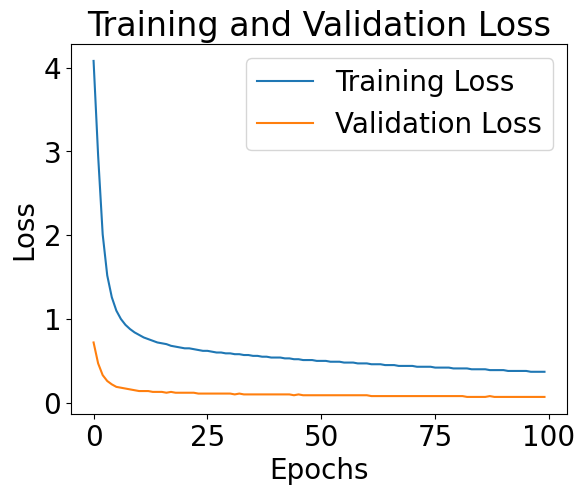

learning rate = 0.1: 100%|██████████| 100/100 [03:39<00:00,  2.20s/it]


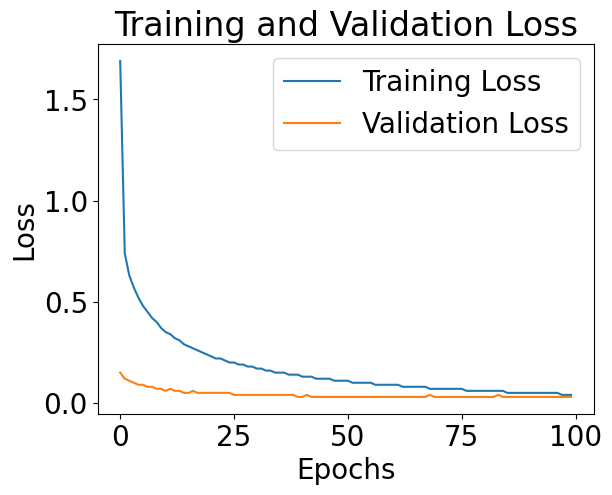

learning rate = 1: 100%|██████████| 100/100 [03:42<00:00,  2.22s/it]


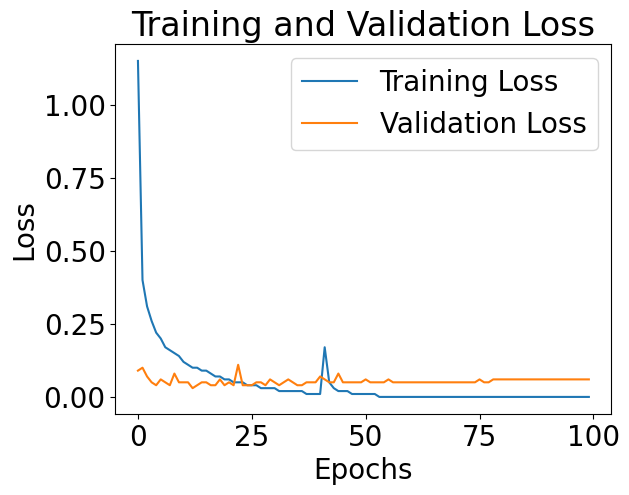

In [14]:
# Code for running experiments

print(device) # make sure you're using GPU instance
torch.manual_seed(0) # to avoid randomness, but if you wanted to create an ensemble, you should not use a manual seed

# TODO (set up dataloaders, and call training function)
trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(np.eye(10)[y_train]))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=1)

valset = torch.utils.data.TensorDataset(torch.Tensor(x_val), torch.Tensor(np.eye(10)[y_val]))
val_loader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=True, num_workers=1)

mlp1, loss1 = train_MLP_mnist(train_loader, val_loader, lr=0.01, num_epochs=100)
mlp2, loss2 = train_MLP_mnist(train_loader, val_loader, lr=0.1, num_epochs=100)
mlp3, loss3 = train_MLP_mnist(train_loader, val_loader, lr=1, num_epochs=100)

In [15]:
ind1 = np.argmax(loss1)
print(f"max loss is {loss1[ind1]} for index = {ind1}")
ind2 = np.argmax(loss2)
print(f"max loss is {loss2[ind2]} for index = {ind2}")
ind3 = np.argmax(loss3)
print(f"max loss is {loss3[ind3]} for index = {ind3}")

max loss is 0.72 for index = 0
max loss is 0.15 for index = 0
max loss is 0.11 for index = 22


#### 2b
Based on the loss curves, select the learning rate and number of epochs that minimizes the validation loss.  Retrain that model (if it's not stored), and report training loss, validation loss, training error, validation error, and test error.

learning rate = 1: 100%|██████████| 23/23 [00:50<00:00,  2.19s/it]


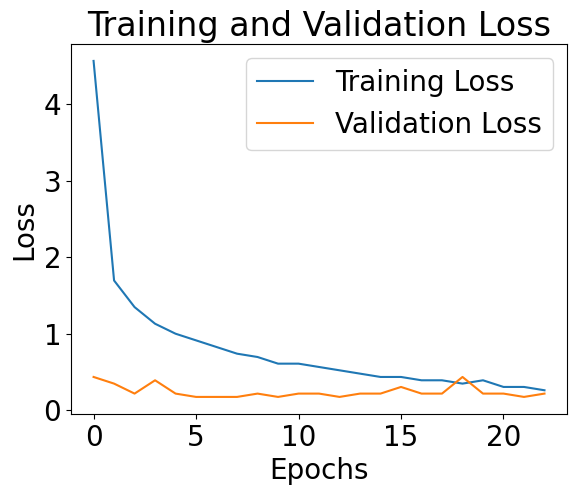

validation loss: 0.12838467834373005, validation error: 0.03200000000000003
test loss: 0.12766104394197464, test error: 0.03359999999999996
train loss: 0.033067768201828, train error: 0.010660000000000003


In [17]:
# TO DO (retrain if needed, and evaluate model on train, val, and test sets)
testset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(np.eye(10)[y_test]))
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True, num_workers=1)
mlp, _ = train_MLP_mnist(train_loader, val_loader, lr=1, num_epochs=23)
val_loss, val_err = evaluate_MLP(mlp, val_loader)
test_loss, test_err = evaluate_MLP(mlp, test_loader)
train_loss, train_err = evaluate_MLP(mlp, train_loader)
print(f"validation loss: {val_loss}, validation error: {val_err}")
print(f"test loss: {test_loss}, test error: {test_err}")
print(f"train loss: {train_loss}, train error: {train_err}")

## Part 3: Predicting Penguin Species

Include all your code for part 3 in this section.  

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
#styling preferences for sns
sns.set_style('whitegrid')
sns.set_context('poster')
datadir = "./" 
df_penguins = pd.read_csv(datadir + 'penguins_size.csv')
df_penguins.head(10)

# convert features with multiple string values to binary features so they can be used by sklearn
def get_penguin_xy(df_penguins):
  data = np.array(df_penguins[['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']])
  y = df_penguins['species']
  ui = np.unique(data[:,0]) # unique island
  us = np.unique(data[:,-1]) # unique sex
  X = np.zeros((len(y), 10))
  for i in range(len(y)):
    f = 0
    for j in range(len(ui)):
      if data[i, f]==ui[j]:
        X[i, f+j] = 1
    f = f + len(ui)
    X[i, f:(f+4)] = data[i, 1:5]
    f=f+4
    for j in range(len(us)):
      if data[i, 5]==us[j]:
        X[i, f+j] = 1
  feature_names = ['island_biscoe', 'island_dream', 'island_torgersen', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_female', 'sex_male', 'sex_unknown']
  X = pd.DataFrame(X, columns=feature_names)
  return(X, y, feature_names, np.unique(y))

In [ ]:
get_penguin_xy(df_penguins)[0].to_csv("X.csv")

#### 3a
Spend some time to visualize different pairs of features and their relationships to the species.  We’ve done one for you.  Include in your report at least two other visualizations.

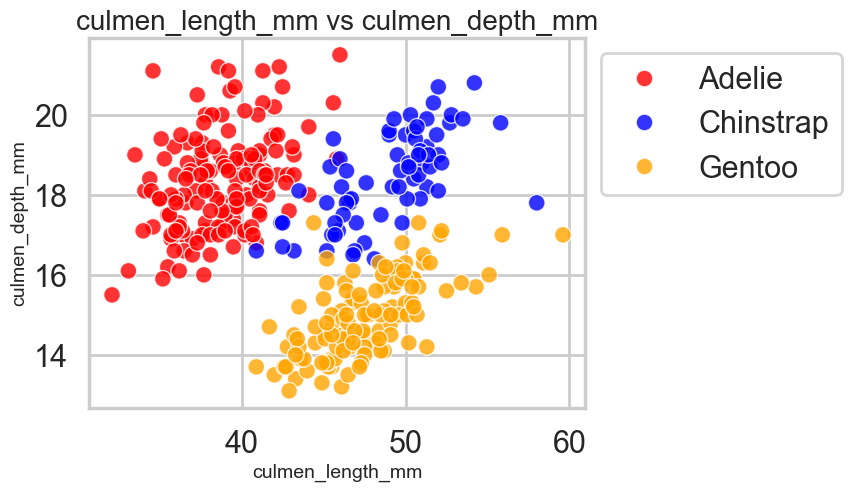

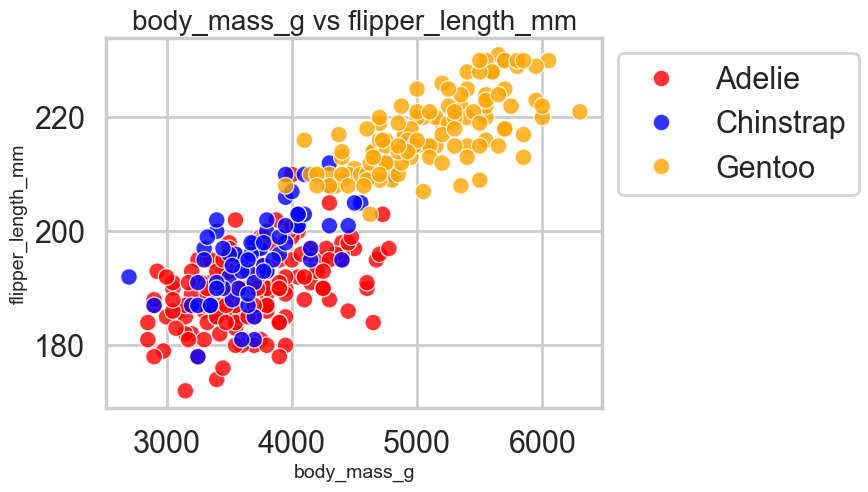

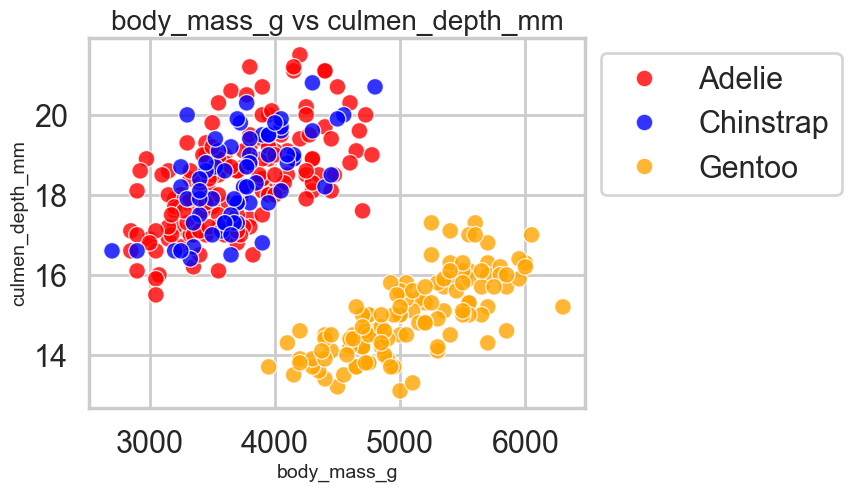

In [ ]:
def plot_scatter(feature1, feature2):
  '''
  Provide names of two features to create a scatterplot of them
  E.g. plot_scatter('culmen_length_mm', 'culmen_depth_mm')
  Possible features: 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'
  '''

  palette = ["red", "blue", "orange"]

  sns.scatterplot(data=df_penguins, x = feature1, y = feature2,
               hue = 'species', palette=palette, alpha=0.8)
  # Doc: https://seaborn.pydata.org/generated/seaborn.scatterplot.html

  plt.xlabel(feature1, fontsize=14)
  plt.ylabel(feature2, fontsize=14)
  plt.title(feature1 + ' vs ' + feature2, fontsize=20)
  plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
  plt.show()

# TO DO call plot_scatter with different feature pairs to create some visualizations

plot_scatter('culmen_length_mm', 'culmen_depth_mm')
plot_scatter('body_mass_g', 'flipper_length_mm')
plot_scatter('body_mass_g', 'culmen_depth_mm')

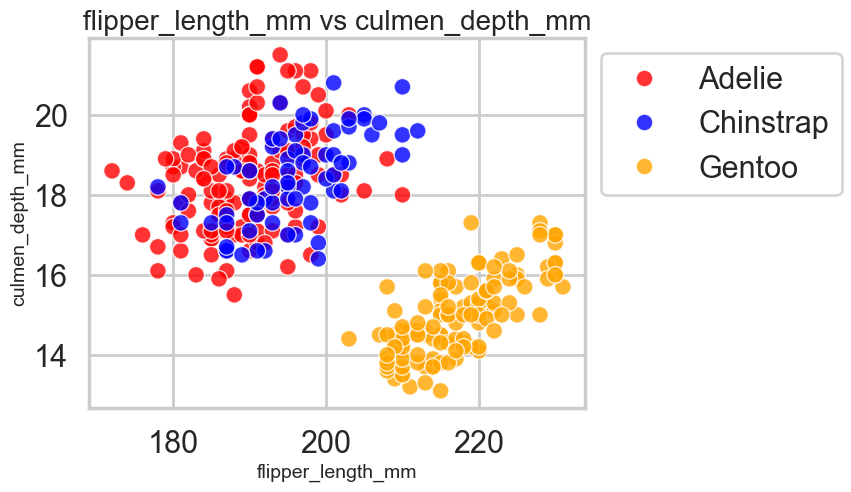

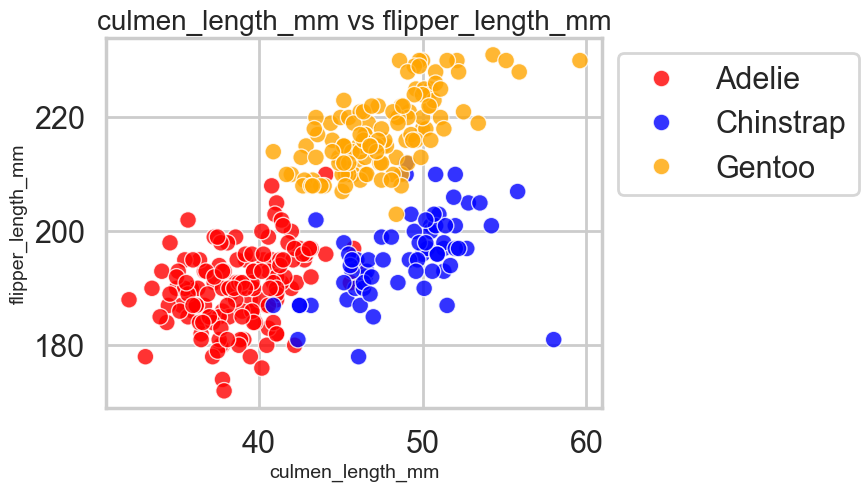

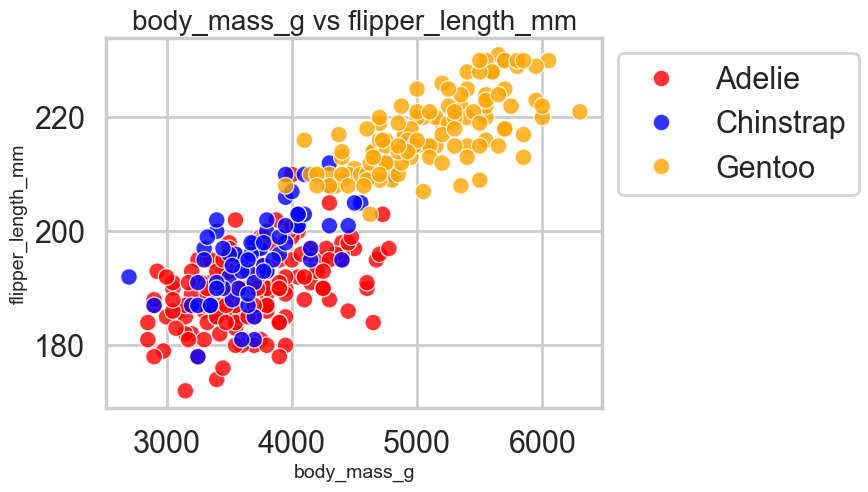

In [ ]:
plot_scatter('flipper_length_mm', 'culmen_depth_mm')
plot_scatter('culmen_length_mm', 'flipper_length_mm')
plot_scatter('body_mass_g', 'flipper_length_mm')

#### 3b
Suppose you want to be able to identify the Gentoo species with a simple rule with very high accuracy.  Use a decision tree classifier to figure out such a rule that has only two checks (e.g. “mass greater than 4000 g, and culmen length less than 40 mm is Gentoo; otherwise, not”).   You can use the library DecisionTreeClassifier with either ‘gini’ or ‘entropy’ criterion. Use sklearn.tree.plot_tree with feature_names and class_names arguments to visualize the decision tree.  Include the tree that you used to find the rule in your report and the rule.

[Text(0.5, 0.8333333333333334, 'culmen_length_mm <= 42.35\ngini = 0.636\nsamples = 341\nvalue = [151, 68, 122]\nclass = Adelie'),
 Text(0.25, 0.5, 'body_mass_g <= 4625.0\ngini = 0.055\nsamples = 143\nvalue = [139, 1, 3]\nclass = Adelie'),
 Text(0.125, 0.16666666666666666, 'gini = 0.029\nsamples = 138\nvalue = [136, 1, 1]\nclass = Adelie'),
 Text(0.375, 0.16666666666666666, 'gini = 0.48\nsamples = 5\nvalue = [3, 0, 2]\nclass = Adelie'),
 Text(0.75, 0.5, 'body_mass_g <= 4175.0\ngini = 0.521\nsamples = 198\nvalue = [12, 67, 119]\nclass = Gentoo'),
 Text(0.625, 0.16666666666666666, 'gini = 0.192\nsamples = 67\nvalue = [5, 60, 2]\nclass = Chinstrap'),
 Text(0.875, 0.16666666666666666, 'gini = 0.197\nsamples = 131\nvalue = [7, 7, 117]\nclass = Gentoo')]

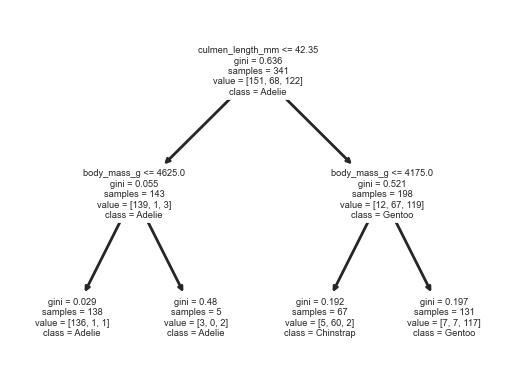

In [ ]:
# TO DO (Train a short tree to identify a good rule, plot the tree, report the rule and its precision/recall in your report)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

classify = DecisionTreeClassifier(max_depth=2)
features = df_penguins[["body_mass_g", "culmen_length_mm"]]
target = df_penguins["species"]
classify.fit(features, target)
plot_tree(classify, feature_names=["body_mass_g", "culmen_length_mm"], class_names=np.unique(target))

In [ ]:
pred = classify.predict(features)

print(np.sum((pred=="Gentoo")&(target=="Gentoo")))
print(pred.shape[0])
print(np.sum((pred=="Gentoo")&(target=="Gentoo")))
print(np.sum(target=="Gentoo"))

117
341
117
122


#### 3c

Use any method at your disposal to achieve maximum 5-fold cross-validation accuracy on this problem. To keep it simple, we will use sklearn.model_selection to perform the cross-validation for us. Report your model design and 5-fold accuracy.  It is possible to get more than 99% accuracy.

In [ ]:
# design a classification model, import libraries as needed
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

X, y, feature_names, class_names = get_penguin_xy(df_penguins)

# TO DO -- choose some model and fit the data
model = LogisticRegression()
scores = cross_val_score(model, np.array(X), np.array(y), cv=5)
print('CV Accuracy: {}'.format(scores.mean()))

from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
scores = cross_val_score(model, np.array(X), np.array(y), cv=5)
print('CV Accuracy: {}'.format(scores.mean()))

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
scores = cross_val_score(model, np.array(X), np.array(y), cv=5)
print('CV Accuracy: {}'.format(scores.mean()))

from sklearn.svm import SVC
model = SVC()
scores = cross_val_score(model, np.array(X), np.array(y), cv=5)
print('CV Accuracy: {}'.format(scores.mean()))

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
scores = cross_val_score(model, np.array(X), np.array(y), cv=5)
print('CV Accuracy: {}'.format(scores.mean()))

CV Accuracy: 0.9883205456095482
CV Accuracy: 0.9764705882352942
CV Accuracy: 0.9911764705882353
CV Accuracy: 0.7331628303495311
CV Accuracy: 0.7890451832907076


## Part 4: Stretch Goals
Include any new code needed for Part 4 here

In [ ]:
# TO DO (optional)
# TO DO (optional)
import numpy as np
from keras.datasets import mnist
from matplotlib import pyplot as plt
from scipy import stats
import torch
import torch.nn as nn

def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

# create train/val split
ntrain = 50000
x_val = x_train[ntrain:].copy()
y_val = y_train[ntrain:].copy()
x_train = x_train[:ntrain]
y_train = y_train[:ntrain]

def display_error_curves(training_losses, validation_losses):
  """
  Plots the training and validation loss curves
  training_losses and validation_losses should be lists or arrays of the same length
  """
  num_epochs = len(training_losses)

  plt.plot(range(num_epochs), training_losses, label="Training Loss")
  plt.plot(range(num_epochs), validation_losses, label="Validation Loss")

  # Add in a title and axes labels
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  # Display the plot
  plt.legend(loc='best')
  plt.show()

# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 2*hidden_size)  
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(2*hidden_size, hidden_size)  
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, hidden_size//2)  
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size//2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x
    
    
# This is a possible function definition for training MLP, but feel free to change it
# You may also want to create helper functions, e.g. for computing loss or prediction
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

def train_MLP_mnist(train_loader, val_loader, lr=1e-1, num_epochs=100):
  '''
  Train a MLP
  Input: train_loader and val_loader are dataloaders for the training and
  val data, respectively. lr is the learning rate, and the network will
  be trained for num_epochs epochs.
  Output: return a trained MLP
  '''
  # TODO: fill in all code

  input_size = 784
  hidden_size = 64
  output_size = 10

  # Instantiate the model
  mlp = MLP(input_size, hidden_size, output_size)
  optimizer = optim.Adam(mlp.parameters(), lr=lr)
  training_losses, validation_losses = [], []
  loss_function = torch.nn.CrossEntropyLoss()
  
  # Train the model, compute and store train/val loss at each epoch
  for epoch in tqdm(range(0, num_epochs), desc=f"learning rate = {lr}"):    
    # Iterate over the DataLoader for training data
    
    sum_train = 0
    sum_val = 0
    
    for i, data in enumerate(train_loader, 0):    
      inputs, targets = data # Get inputs  
      optimizer.zero_grad() # Zero the gradients
      outputs = mlp(inputs) # Compute logit scores for current batch
      loss = loss_function(outputs, targets) # Compute loss
      loss.backward() # Backprop loss
      optimizer.step() # Update weights
      sum_train += loss
      
    for i, data in enumerate(val_loader, 0):    
      inputs, targets = data # Get inputs  
      optimizer.zero_grad() # Zero the gradients
      outputs = mlp(inputs) # Compute logit scores for current batch
      loss = loss_function(outputs, targets) # Compute loss
      sum_val += loss
      
    # print(type(sum_train))
    training_losses.append(int(sum_train))
    validation_losses.append(int(sum_val))
      
  # Display Loss Curves
  # display_error_curves(training_losses, validation_losses)
  return mlp, validation_losses


def evaluate_MLP(mlp, loader):
  ''' Computes loss and error rate given your mlp model and data loader'''
  N = 0
  acc = 0
  loss = 0
  loss_function = torch.nn.CrossEntropyLoss()
  with torch.set_grad_enabled(False):
    for i, data in enumerate(loader, 0):

      # Get inputs
      inputs, targets = data
      N += len(targets)

      # Perform forward pass
      outputs = mlp(inputs.to(device))

      # Compute sum of correct labels
      y_pred = np.argmax(outputs.cpu().numpy(), axis=1)
      y_gt = np.argmax(targets.numpy(), axis=1)
      acc += np.sum(y_pred==y_gt)

      # Compute loss
      loss += loss_function(outputs, targets.to(device)).item()*len(targets)

  loss /= N
  acc /= N

  return loss, 1-acc

# Code for running experiments

# print(device) # make sure you're using GPU instance
torch.manual_seed(0) # to avoid randomness, but if you wanted to create an ensemble, you should not use a manual seed

# TODO (set up dataloaders, and call training function)
trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(np.eye(10)[y_train]))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=1)

valset = torch.utils.data.TensorDataset(torch.Tensor(x_val), torch.Tensor(np.eye(10)[y_val]))
val_loader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=True, num_workers=1)

mlp1, loss1 = train_MLP_mnist(train_loader, val_loader, lr=0.001, num_epochs=100)
mlp2, loss2 = train_MLP_mnist(train_loader, val_loader, lr=0.01, num_epochs=100)
mlp3, loss3 = train_MLP_mnist(train_loader, val_loader, lr=0.1, num_epochs=100)

ind1 = np.argmax(loss1)
print(f"max loss is {loss1[ind1]} for index = {ind1}")
ind2 = np.argmax(loss2)
print(f"max loss is {loss2[ind2]} for index = {ind2}")
ind3 = np.argmax(loss3)
print(f"max loss is {loss3[ind3]} for index = {ind3}")

# TO DO (retrain if needed, and evaluate model on train, val, and test sets)
# Sets device to "cuda" if a GPU is available  (in Colabs, enable GPU by Edit->Notebook Settings-->Hardware Accelerator=GPU)
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device) # make sure you're using GPU instance
testset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(np.eye(10)[y_test]))
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True, num_workers=1)
if loss1[ind1]>loss2[ind2]:
  if loss1[ind1]>loss3[ind3]:
    lr=0.001
    num_epochs=ind1
  else:
    lr=0.1
    num_epochs=ind3
else:
  if loss2[ind2]>loss3[ind3]:
    lr=0.01
    num_epochs=ind2
  else:
    lr=0.1
    num_epochs=ind3
mlp, _ = train_MLP_mnist(train_loader, val_loader, lr=lr, num_epochs=num_epochs)
val_loss, val_err = evaluate_MLP(mlp, val_loader)
test_loss, test_err = evaluate_MLP(mlp, test_loader)
train_loss, train_err = evaluate_MLP(mlp, train_loader)
print(f"validation loss: {val_loss}, validation error: {val_err}")
print(f"test loss: {test_loss}, test error: {test_err}")
print(f"train loss: {train_loss}, train error: {train_err}")


learning rate = 0.1: 100%|██████████| 100/100 [07:56<00:00,  4.76s/it]


max loss is 11 for index = 0
max loss is 11 for index = 83
max loss is 81 for index = 18
cpu


learning rate = 0.1: 100%|██████████| 18/18 [01:27<00:00,  4.85s/it]


validation loss: 0.7412997485160827, validation error: 0.21640000000000004
test loss: 0.7280186690330506, test error: 0.22219999999999995
train loss: 0.7102787209129333, train error: 0.21914


121
341
121
122


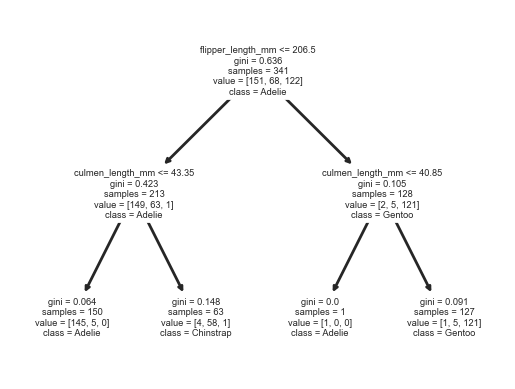

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
#styling preferences for sns
sns.set_style('whitegrid')
sns.set_context('poster')
datadir = "./" 
df_penguins = pd.read_csv(datadir + 'penguins_size.csv')
df_penguins.head(10)

# convert features with multiple string values to binary features so they can be used by sklearn
def get_penguin_xy(df_penguins):
  data = np.array(df_penguins[['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']])
  y = df_penguins['species']
  ui = np.unique(data[:,0]) # unique island
  us = np.unique(data[:,-1]) # unique sex
  X = np.zeros((len(y), 10))
  for i in range(len(y)):
    f = 0
    for j in range(len(ui)):
      if data[i, f]==ui[j]:
        X[i, f+j] = 1
    f = f + len(ui)
    X[i, f:(f+4)] = data[i, 1:5]
    f=f+4
    for j in range(len(us)):
      if data[i, 5]==us[j]:
        X[i, f+j] = 1
  feature_names = ['island_biscoe', 'island_dream', 'island_torgersen', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_female', 'sex_male', 'sex_unknown']
  X = pd.DataFrame(X, columns=feature_names)
  return(X, y, feature_names, np.unique(y))
# TO DO (Train a short tree to identify a good rule, plot the tree, report the rule and its precision/recall in your report)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

classify = DecisionTreeClassifier(max_depth=2)
features = df_penguins[["flipper_length_mm", "culmen_length_mm"]]
target = df_penguins["species"]
classify.fit(features, target)
plot_tree(classify, feature_names=["flipper_length_mm", "culmen_length_mm"], class_names=np.unique(target))
pred = classify.predict(features)

print(np.sum((pred=="Gentoo")&(target=="Gentoo")))
print(pred.shape[0])
print(np.sum((pred=="Gentoo")&(target=="Gentoo")))
print(np.sum(target=="Gentoo"))